# 08 - Model Testing: Extending to other Cantons
### Author: Daniel Herrera-Russert
#### March 28, 2025

In [1]:
from owslib.wfs import WebFeatureService
import geopandas as gpd
from io import BytesIO
import os
import requests
import matplotlib.pyplot as plt
import json
import time
import re
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

## 1. Cross-Cantonal Model Evaluation: Zurich to Luzern

As a continuation of the model evaluation, and especially in light of its surprisingly strong performance, we now turn to a critical question:

> Did the XGBoost model successfully capture underlying patterns in geothermal heat yield across the canton of Zurich due to regional homogeneity, or is it overfitting to localized data?

To address this, we test the model's ability to generalize by applying it to new data from the canton of **Luzern**. If the model performs well, this would suggest that the framework is not only robust but also extensible, and therefore an important step toward developing a nation-wide predictive tool for geothermal potential, without relying on the complexities of incorporating and modelling underground geological factors.

The Luzern dataset is a strong candidate for this evaluation, as it is structured similarly to Zurich's and likely shares comparable geographical and human useage characteristics. However, Luzern also presents new geological conditions, such as the presence of larger Voralpine mountain chains, which are absent in Zurich. These differences make it a valuable test case for assessing the model’s transferability to more geologically diverse locations in Switzerland.

The dataset can be accessed from the official [open data portal of the canton of Luzern](https://daten.geo.lu.ch/download/ewnutzxx_col_v3). Additionally, a [documentation page](https://daten.geo.lu.ch/produkt/ewnutzxx_col_v3) with a glossary for all fields can be found in the same portal.

---

### 1.1. Loading the Cantonal Boundary for Luzern

In [2]:
# URL of the GeoJSON file
geojson_url = "https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-kanton-flaeche.fill/3?geometryFormat=geojson&sr=4326"

# Define output file path
output_geojson = "../data/raw/luzern/lu_boundary.geojson"

# Fetch the GeoJSON data
response = requests.get(geojson_url)

# Save to file
if response.status_code == 200:
    with open(output_geojson, "wb") as f:
        f.write(response.content)
    print(f"✅ Luzern boundary saved as '{output_geojson}'")
else:
    print("❌ Failed to download GeoJSON data.")

# Load into GeoPandas
boundary_gdf = gpd.read_file(output_geojson)

# Print CRS (coordinate system)
print(f"🗺️ Coordinate System: {boundary_gdf.crs}")

✅ Luzern boundary saved as '../data/raw/luzern/lu_boundary.geojson'
🗺️ Coordinate System: EPSG:4326


---

### 1.2. Assessment of the Erdwärmenutzung Dataset from Luzern

Because the data downloaded manually from the cantonal portal contains significantly more data points than the one retrieved via WFS service, likely due to hard limitations on data calls, we proceed with the first one for the analysis and validation of the Zürich model. The data was retrieved on the 29 of March 2025, and contains **13,938 rows**, and was downloaded as a shapefile.

In [3]:
lu_erdwaermenutzung_anlagen_gdf = gpd.read_file("../data/raw/luzern/EWNUTZXX_COL_V3_shp/daten/ERDWNUTZ_V1_PT.shp")
print(f"Number of items: {len(lu_erdwaermenutzung_anlagen_gdf)}")

# Load boundary
boundary_gdf = gpd.read_file("../data/raw/luzern/lu_boundary.geojson").to_crs("EPSG:2056")

lu_erdwaermenutzung_anlagen_gdf.head()

Number of items: 13839


,UUID,NUTZNR,SONDENART,STATUS,BEWDAT,REALISIERU,BETRIEBSZU,PARZELLEN,GBPER_NAME,BOHRUNGNAM,...,LAGENERKOE,BOPRWASSZU,BOPRGAS,BOPRKAVERN,BOPRANDERE,BEI_PZPLAN,BEI_HYDROL,BEI_ZUSVER,BEI_ANDERE,geometry
0,EDCC50F4FCDDE4ECE04028C2DFBD3740,006.109.1,99,1,1990/04/19,99,3,707,Rickenbach,None,...,None,0,0,0,0,0,0,0,0,POINT (2652551 1232850)
1,EDCC50F4F6A3E4ECE04028C2DFBD3740,005.130.1,99,1,2006/08/21,99,3,2240,Malters,None,...,None,0,0,0,0,0,0,0,0,POINT (2656496 1210630)
2,EDCC50F4E99FE4ECE04028C2DFBD3740,002.209.1,99,1,2005/11/07,99,99,1590,Adligenswil,None,...,None,0,0,0,0,0,0,0,0,POINT (2670130 1213365)
3,EDCC50F4F40BE4ECE04028C2DFBD3740,005.260.1,99,1,1996/08/16,99,3,1709,Meggen,None,...,None,0,0,0,0,0,0,0,0,POINT (2670340 1211020)
4,040836ecaf8c437fbbeb305688ffe31d,044.768.1,1,1,2020/02/13,1,1,2323,Escholzmatt,None,...,None,1,0,0,0,1,0,0,0,POINT (2637855 1196575)


A look into all the column names will allow us to identify the shared variables with the Zürich dataset:

In [4]:
for i in list(lu_erdwaermenutzung_anlagen_gdf.columns):
    print(i)

UUID
NUTZNR
SONDENART
STATUS
BEWDAT
REALISIERU
BETRIEBSZU
PARZELLEN
GBPER_NAME
BOHRUNGNAM
BOHRART
BOHRTIEFE
BOHRDURCHM
FELSTIEFE
SONDEN_ANZ
SONDSYSTEM
SONDLAENTO
SONDLAENEI
LEISTUNGAN
ZCK_HEIZUN
ZCK_KUEHLU
ZCK_WAWASS
ZCK_REGENE
ZCK_ANDERE
PUMPART
PUMPFABRIK
PUMPLEISTU
WAERMTRAEG
LAGENERKOE
BOPRWASSZU
BOPRGAS
BOPRKAVERN
BOPRANDERE
BEI_PZPLAN
BEI_HYDROL
BEI_ZUSVER
BEI_ANDERE
geometry


A look at all the variables contained within the Luzern dataset shows a match with the raw version of the Zürich version used for training the XGBoost model, with the following equivalent fields:

| Column Name ZH | Column Name LU | Description |
|----------------------|-----------------|-------------|
|`WAERMEENTNAHME`|`PUMPLEISTUNG`|Power output of the heat pump system (kW).|
|`SONDENTIEFE`|`BOHRTIEFE`|Drilling depth in meters.|
|`GESAMTSONDENANZAHL`|`SONDEN_ANZ`|Number of probes per installation.|
|`geometry`|`geometry`| Coordinates encoded as GeoJSON points. |

Additionally, the engineered spatial variables are required to run the new data through the predictive model, two of which (`nearest_borehole_dist` and `count_100m`) can be produced via geographical queries with the coordinate data stored in the `geometry` column, and the third `bottom_elevation` requiring the addition of the top elevation of each recorded point. This will be tackled next, as a fundamental step in enriching the dataset for the model features.

Another notable observation is the significantly richer descriptive quality of the Luzern dataset. It contains complementary attributes that are absent in the Zürich dataset, offering greater detail and nuance regarding EWS installations. This enhanced granularity could help capture unique geological characteristics and system-specific differences, potentially leading to more accurate and insightful analyses.


| Column Name LU  | Description                                 |
|------------------|---------------------------------------------|
| `SONDLAENTO`     | Sum length of all probes (m).               |
| `SONDLAENEI`     | Individual probe length (m).                |
| `FELSTIEFE`      | Depth to bedrock (m).                       |
| `BOHRDURCHM`     | Diameter of the borehole (mm).              |
| `WAERMTRAEG`     | Type of heat transfer fluid.                |
| `SONDSYSTEM`     | Configuration of the probe system (e.g., U-pipe). |

Given the project's primary focus on datasets from the canton of Zürich, this aspect will not be explored further at this stage. However, it is flagged as a valuable opportunity for future research, especially for expanding the scope and enhancing the depth of analysis in subsequent iterations of the study.

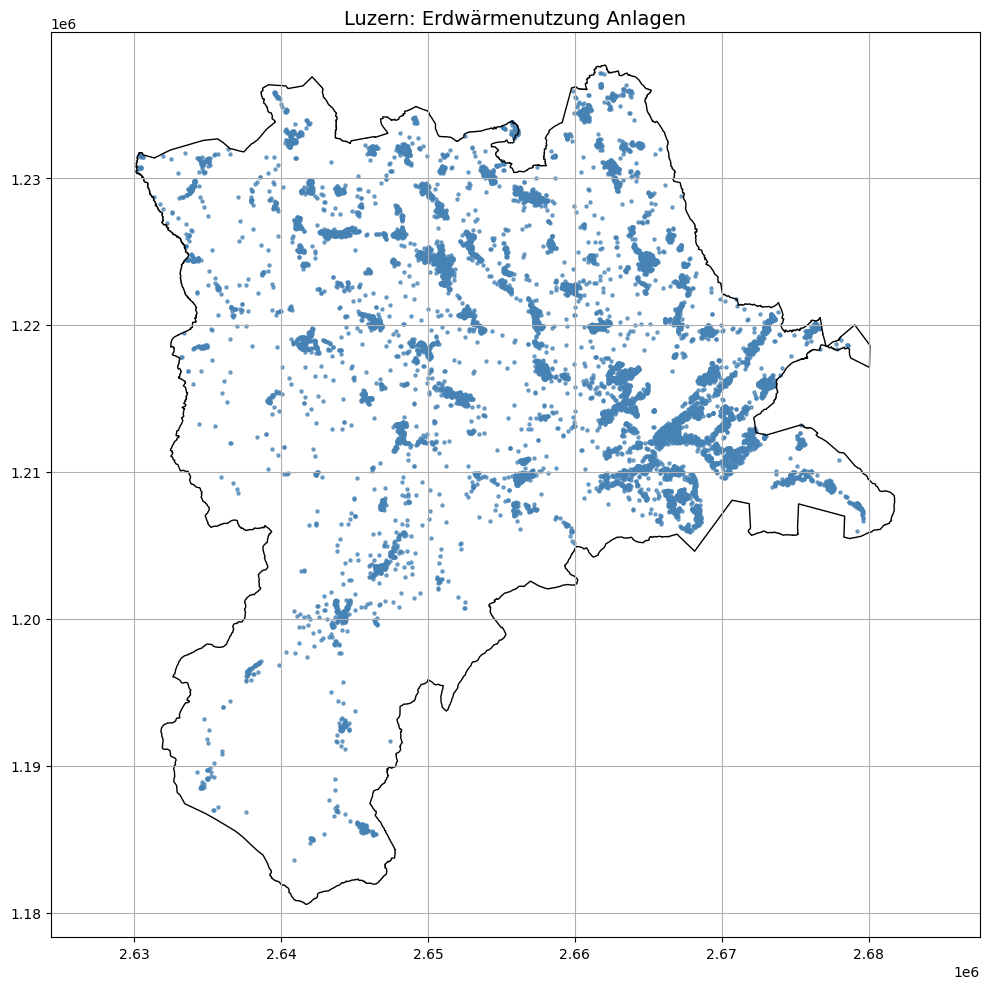

In [5]:
# Quick geographic plot
fig, ax = plt.subplots(figsize=(10, 10))
lu_erdwaermenutzung_anlagen_gdf.plot(ax=ax, markersize=5, color="steelblue", alpha=0.7)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

plt.title("Luzern: Erdwärmenutzung Anlagen", fontsize=14)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

---

### 1.3. Implementing the Engineered Features

The remaining raw variable needed to complete all 3 engineered features is the top elevation of the ground heat installation for each point. The first step is to produce a subset of the Luzern dataset with the matching columns, and impute missing values in the power output variable.

This step focuses on preparing the Luzern geothermal probe dataset (`lu_erdwaermenutzung_anlagen_gdf`) for analysis by aligning it with the structure used for Zürich. We select only the relevant columns: heat pump output (`PUMPLEISTU`), probe depth (`BOHRTIEFE`), number of probes (`SONDEN_ANZ`), and geometry. These columns are renamed to match the Zürich naming convention: `Waermeentnahme`, `Sondentiefe`, and `Gesamtsondenzahl`.

Since the heat yield column (`PUMPLEISTU`) is stored as text and may contain commas as decimal separators, we first clean and convert it to numeric format. After this, we remove all rows that contain missing (`NaN`) values in any of the three key numeric fields, as these rows would be invalid or incomplete for modeling and analysis. This last measure has perhaps the most radical effect, as it removes close to half of the data points from the data, but it was deemed necessary in order to make a comparable interpreation of the data by the same terms as Zürich's.

In [6]:
# Subset and rename columns to match Zürich naming convention
lu_subset = lu_erdwaermenutzung_anlagen_gdf[[
    "PUMPLEISTU",    # Heat pump power output (text, kW)
    "BOHRTIEFE",     # Drilling depth (m)
    "SONDEN_ANZ",    # Number of probes
    "geometry"       # Spatial geometry
]].rename(columns={
    "PUMPLEISTU": "Waermeentnahme",
    "BOHRTIEFE": "Sondentiefe",
    "SONDEN_ANZ": "Gesamtsondenzahl"
})

# Clean and convert Waermeentnahme to numeric (e.g., replace commas with dots)
lu_subset["Waermeentnahme"] = (
    lu_subset["Waermeentnahme"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .apply(pd.to_numeric, errors="coerce")
)

# Count rows before dropping NaNs
initial_count = len(lu_subset)

# Drop rows with missing values in key columns
lu_subset = lu_subset.dropna(subset=["Waermeentnahme", "Sondentiefe", "Gesamtsondenzahl"])

# Count rows after cleaning
final_count = len(lu_subset)
removed_count = initial_count - final_count

print(f"✅ Removed {removed_count} rows with missing values in `Waermeentnahme`.")

# Optional: Reset index
lu_subset = lu_subset.reset_index(drop=True)

# Preview result
print(lu_subset.info())
print(lu_subset.describe())

✅ Removed 6427 rows with missing values in `Waermeentnahme`.
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Waermeentnahme    7412 non-null   float64 
 1   Sondentiefe       7412 non-null   float64 
 2   Gesamtsondenzahl  7412 non-null   int64   
 3   geometry          7412 non-null   geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 231.8 KB
None
       Waermeentnahme  Sondentiefe  Gesamtsondenzahl
count     7412.000000  7412.000000       7412.000000
mean        21.487696   154.979493          2.320831
std         30.146985    98.629244          3.057208
min          0.000000     0.000000          0.000000
25%          8.650000   110.000000          1.000000
50%         13.560000   182.000000          2.000000
75%         25.600000   220.000000          3.000000
max        800.000000  2201.000000         

In [7]:
lu_subset.describe()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl
count,7412.000000,7412.000000,7412.000000
mean,21.487696,154.979493,2.320831
std,30.146985,98.629244,3.057208
min,0.000000,0.000000,0.000000
25%,8.650000,110.000000,1.000000
50%,13.560000,182.000000,2.000000
75%,25.600000,220.000000,3.000000
max,800.000000,2201.000000,90.000000


The following code leverages the **Swisstopo API** to assign an elevation value in metres above sea level to each geographical point from the Luzern dataset:

In [8]:
# Function to get elevation from swisstopo API
def get_elevation(easting, northing):
    url = "https://api3.geo.admin.ch/rest/services/height"
    params = {
        "easting": easting,
        "northing": northing,
        "sr": 2056
    }
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        r = requests.get(url, params=params, headers=headers)
        if r.status_code == 200:
            return float(r.json().get("height", None))
    except Exception as e:
        print(f"⚠️ Error at point ({easting}, {northing}): {e}")
    return None

# Add elevation to the dataframe
elevations = []

print("📡 Fetching elevation for all points...")
for idx, row in lu_subset.iterrows():
    x, y = row.geometry.x, row.geometry.y
    elevation = get_elevation(x, y)
    elevations.append(elevation)

    if idx % 1000 == 0 and idx != 0:
        print(f"✅ Processed {idx} points")

    time.sleep(0.05)  # avoid hitting rate limits

# Assign new column
lu_subset["top_elevation"] = elevations

# Create output directory if it doesn't exist
output_path = "../data/transformed"
os.makedirs(output_path, exist_ok=True)

# Save GeoDataFrame
output_file = os.path.join(output_path, "lu_geothermal_probes.geojson")
lu_subset.to_file(output_file, driver="GeoJSON")

print(f"✅ Done! Saved to: {output_file}")

📡 Fetching elevation for all points...
✅ Processed 1000 points
✅ Processed 2000 points
✅ Processed 3000 points
✅ Processed 4000 points
✅ Processed 5000 points
✅ Processed 6000 points
✅ Processed 7000 points
✅ Done! Saved to: ../data/transformed\lu_geothermal_probes.geojson


In [34]:
# Load the file back from scratch
lu_subset_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

In [35]:
lu_subset.head()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl,geometry,top_elevation,count_100m,nearest_borehole_dist,bottom_elevation
0,12.00,210.0,1,POINT (2637855 1196575),854.6,1,40.607881,644.6
1,11.70,210.0,1,POINT (2643491 1226265),536.7,11,7.000000,326.7
2,58.79,300.0,2,POINT (2650771 1223740),505.8,13,34.409301,205.8
3,30.70,200.0,3,POINT (2647750 1224145),540.3,1,55.036352,340.3
4,25.60,232.0,2,POINT (2642322 1224933),515.1,0,114.140265,283.1


---

#### 1.3.1. Count within 100 m

In [36]:
# Extract coordinate tuples directly from geometry
coords = np.array([(point.x, point.y) for point in lu_subset.geometry])
# Create KDTree for efficient spatial queries
tree = cKDTree(coords)

In [37]:
r = 100
print(f"Computing radius {r}m ...")
lu_subset[f'count_{r}m'] = [len(tree.query_ball_point(coord, r)) - 1 for coord in coords]
print(f"✔")

# Save the updated dataset
output_path = "../data/transformed/lu_geothermal_probes.geojson"
lu_subset.to_file(output_path, driver="GeoJSON")

# Display first few rows
lu_subset.head()[["count_100m"]]

Computing radius 100m ...
✔


,count_100m
0,1
1,11
2,13
3,1
4,0


---

#### 1.3.2. Nearest Neighbour Distance

In [38]:
# Extract coordinate tuples from geometry
coords = np.array([(point.x, point.y) for point in lu_subset.geometry])

# Create KDTree
tree = cKDTree(coords)

# Query the nearest neighbor for each point (excluding itself)
distances, indices = tree.query(coords, k=2)  # k=2 because the first result is the point itself

# The second column contains the distance to the nearest neighbor
lu_subset["nearest_borehole_dist"] = distances[:, 1]

# Display first few rows
lu_subset.head()[["nearest_borehole_dist"]]

,nearest_borehole_dist
0,40.607881
1,7.000000
2,34.409301
3,55.036352
4,114.140265


---

#### 1.3.3. Bottom Elevation

In [39]:
# Compute bottom elevation
lu_subset["bottom_elevation"] = lu_subset["top_elevation"] - lu_subset["Sondentiefe"]

# Display updated dataframe
lu_subset[["top_elevation", "Sondentiefe", "bottom_elevation"]].head()

,top_elevation,Sondentiefe,bottom_elevation
0,854.6,210.0,644.6
1,536.7,210.0,326.7
2,505.8,300.0,205.8
3,540.3,200.0,340.3
4,515.1,232.0,283.1


---

## 2. Exploration of the Luzern Data

In [40]:
# Load the data from scratch
lu_geothermal_probes_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

In [41]:
lu_geothermal_probes_gdf.isna().sum()

Waermeentnahme           0
Sondentiefe              0
Gesamtsondenzahl         0
top_elevation            0
count_100m               0
nearest_borehole_dist    0
bottom_elevation         0
geometry                 0
dtype: int64

In [42]:
lu_geothermal_probes_gdf.describe()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl,top_elevation,count_100m,nearest_borehole_dist,bottom_elevation
count,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000
mean,21.487696,154.979493,2.320831,560.001619,4.529412,83.859829,405.022126
std,30.146985,98.629244,3.057208,115.419304,5.130763,162.150679,150.246299
min,0.000000,0.000000,0.000000,408.700000,0.000000,0.000000,-1689.200000
25%,8.650000,110.000000,1.000000,492.200000,1.000000,22.321411,300.600000
50%,13.560000,182.000000,2.000000,526.500000,3.000000,38.118237,375.900000
75%,25.600000,220.000000,3.000000,591.100000,6.000000,68.731361,491.525000
max,800.000000,2201.000000,90.000000,1475.800000,43.000000,2899.379934,1461.200000


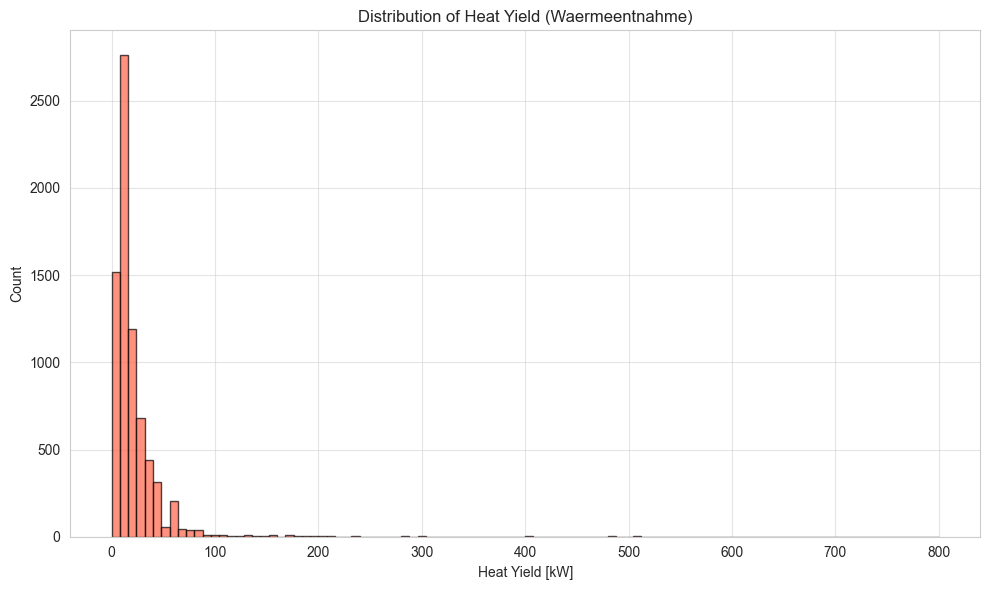

In [43]:
# Set figure size and style
plt.figure(figsize=(10, 6))
plt.hist(lu_geothermal_probes_gdf["Waermeentnahme"], bins=100, color="tomato", alpha=0.7, edgecolor="black")

# Add labels and title
plt.title("Distribution of Heat Yield (Waermeentnahme)")
plt.xlabel("Heat Yield [kW]")
plt.ylabel("Count")

# Optional grid
plt.grid(True, alpha=0.5)
# Show plot
plt.tight_layout()
plt.show()

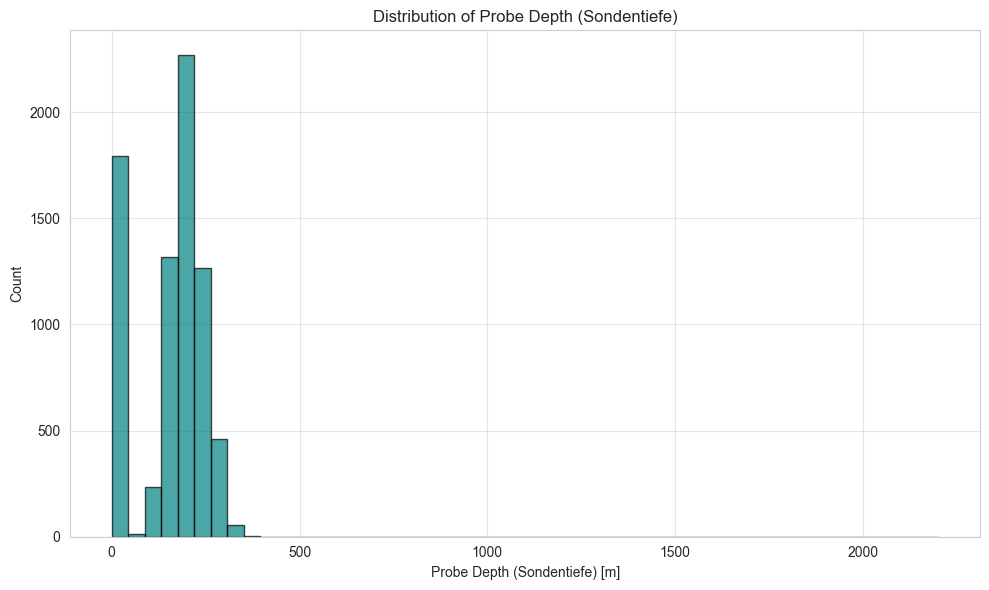

In [44]:
# Set figure size and style
plt.figure(figsize=(10, 6))
plt.hist(lu_geothermal_probes_gdf["Sondentiefe"], bins=50, color="teal", alpha=0.7, edgecolor="black")

# Add labels and title
plt.title("Distribution of Probe Depth (Sondentiefe)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Count")

# Optional grid
plt.grid(True, alpha=0.5)
# Show plot
plt.tight_layout()
plt.show()

The first thing that stands out is the comparetively large portion of probes with little or no depth associated with them, which contrasts with a distribution very similar to the one in the canton Zürich. A quick adjustment by removing the depth 0 items from the data will return an almost identical histogram plot, with most values clustering around the 250 metre mark, as well as a sporadic outlier of around 2,300 metres in depth.

In [45]:
# Filter out installations with zero drilling depth
lu_filtered_depth = lu_geothermal_probes_gdf[lu_geothermal_probes_gdf["Sondentiefe"] > 0].copy()

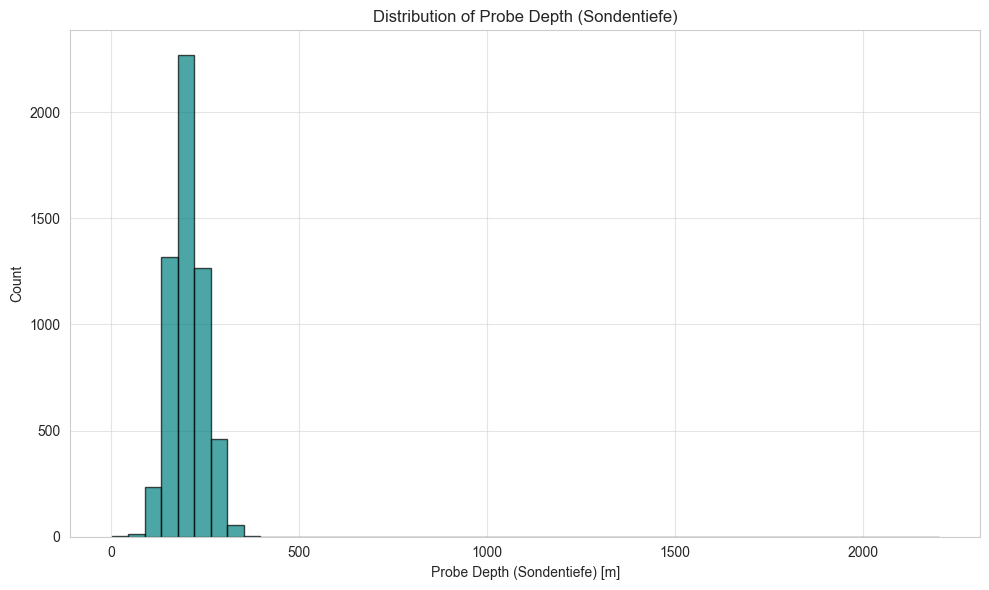

In [46]:
# Set figure size and style
plt.figure(figsize=(10, 6))
plt.hist(lu_filtered_depth["Sondentiefe"], bins=50, color="teal", alpha=0.7, edgecolor="black")

# Add labels and title
plt.title("Distribution of Probe Depth (Sondentiefe)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Count")

# Optional grid
plt.grid(True, alpha=0.5)
# Show plot
plt.tight_layout()
plt.show()

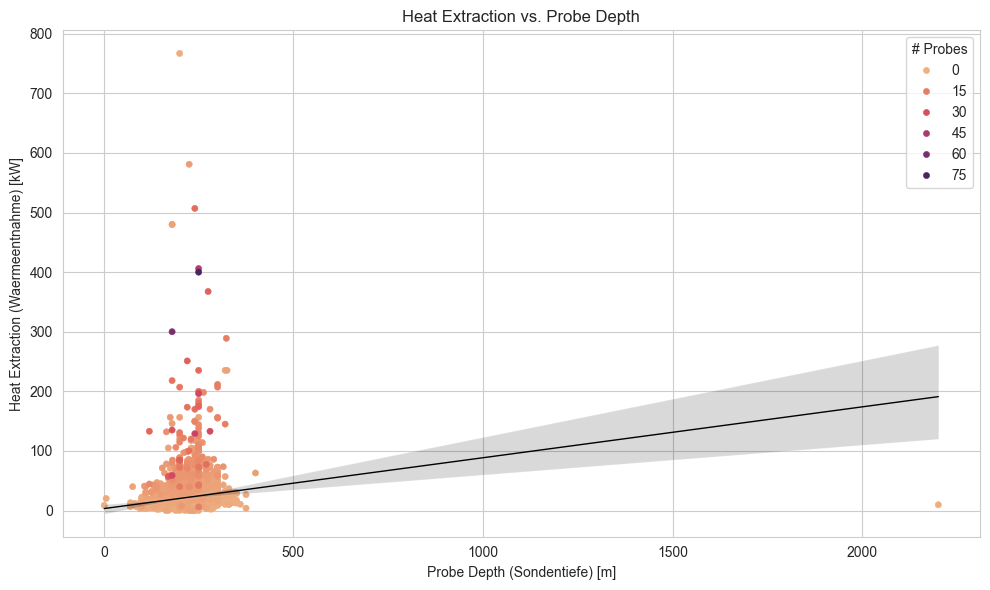

In [47]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Sort so high "Gesamtsondenzahl" values plot last
sorted_df = lu_filtered_depth.sort_values(by="Gesamtsondenzahl", ascending=True)

# Use scatterplot for color encoding
sns.scatterplot(
    data=sorted_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="flare",  # or "coolwarm", "magma", etc.
    alpha=1,
    s=20,
    edgecolor=None,
)

# Add regression line (ignoring hue, purely for trend)
sns.regplot(
    data=lu_filtered_depth,
    x="Sondentiefe",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

plt.title("Heat Extraction vs. Probe Depth")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Heat Extraction (Waermeentnahme) [kW]")
plt.legend(title="# Probes")
plt.tight_layout()
plt.show()

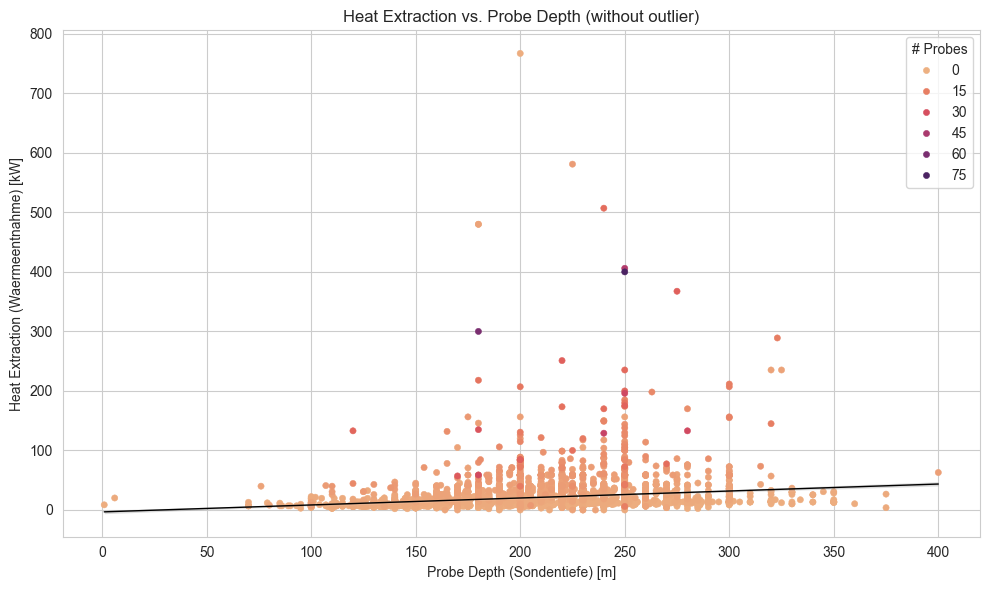

In [48]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

filtered_df = sorted_df[sorted_df["Sondentiefe"] < 2000]

# Use scatterplot for color encoding
sns.scatterplot(
    data=filtered_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="flare",  # or "coolwarm", "magma", etc.
    alpha=1,
    s=20,
    edgecolor=None,
)

# Add regression line (ignoring hue, purely for trend)
sns.regplot(
    data=filtered_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

plt.title("Heat Extraction vs. Probe Depth (without outlier)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Heat Extraction (Waermeentnahme) [kW]")
plt.legend(title="# Probes")
plt.tight_layout()
plt.show()

---

## 3. Running the Predictive Model with Luzern Data

In [49]:
# Load the data from scratch
lu_geothermal_probes_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

# Load the model
model_path = "../models/xgb_zh_energy_yield.pkl"
xgb_model = joblib.load(model_path)

In [50]:
# Define features and target
feature_columns = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]

# Make predictions
X = lu_geothermal_probes_gdf[feature_columns]
y_pred = xgb_model.predict(X)

# Store predictions in a new column
lu_geothermal_probes_gdf.loc[lu_geothermal_probes_gdf.index, 'Waermeentnahme_predicted'] = y_pred

In [51]:
y_true = lu_geothermal_probes_gdf["Waermeentnahme"]
y_pred = lu_geothermal_probes_gdf["Waermeentnahme_predicted"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f} kW")
print(f"RMSE: {rmse:.2f} kW")

R² Score: 0.279
MAE: 8.77 kW
RMSE: 25.59 kW


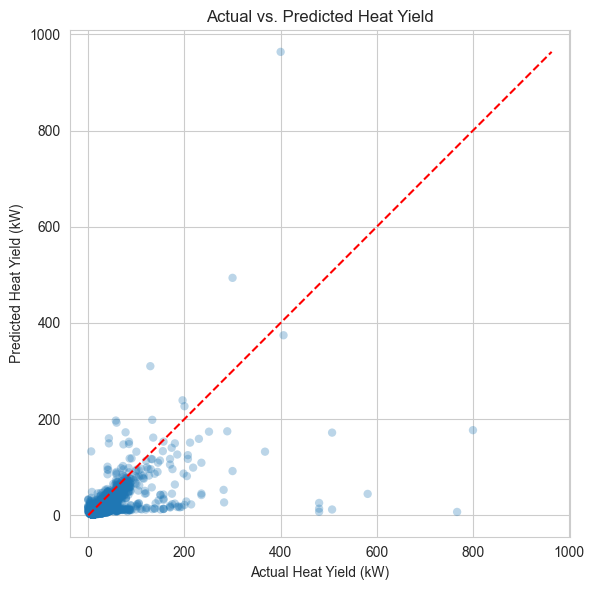

In [52]:
plt.figure(figsize=(6, 6))
plt.scatter(
    lu_geothermal_probes_gdf["Waermeentnahme"],
    lu_geothermal_probes_gdf["Waermeentnahme_predicted"],
    alpha=0.3, edgecolor="none"
)
plt.plot([0, max(y_pred)], [0, max(y_pred)], color='red', linestyle='--')
plt.xlabel("Actual Heat Yield (kW)")
plt.ylabel("Predicted Heat Yield (kW)")
plt.title("Actual vs. Predicted Heat Yield")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

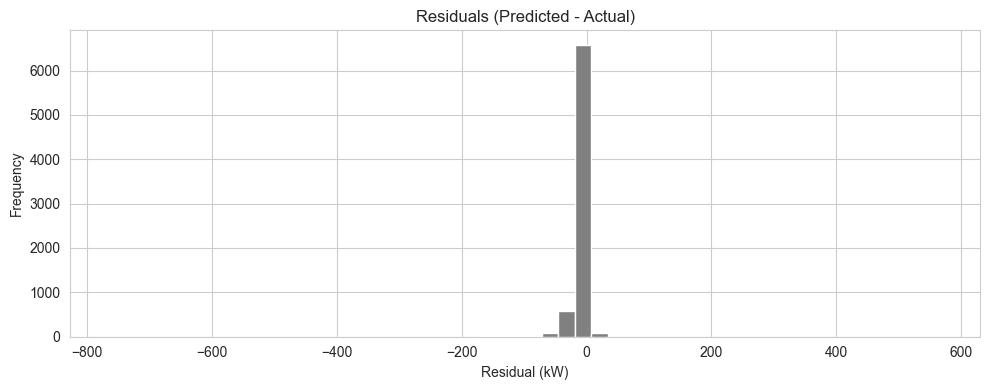

In [53]:
lu_geothermal_probes_gdf["residual"] = (
    lu_geothermal_probes_gdf["Waermeentnahme_predicted"] - lu_geothermal_probes_gdf["Waermeentnahme"]
)

plt.figure(figsize=(10, 4))
plt.hist(lu_geothermal_probes_gdf["residual"], bins=50, color='gray')
plt.title("Residuals (Predicted - Actual)")
plt.xlabel("Residual (kW)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Exluding installations where the recorded heat yield was 0, there were also many with `Sondentiefe` 0.

After consistently cleaning the Luzern dataset by removing entries with missing or invalid values in key fields (`Waermeentnahme`, `Sondentiefe`, `Gesamtsondenzahl`), the XGBoost model trained on data from the canton of Zürich achieved the following results when applied to Luzern:

- **R² Score:** 0.279  
- **MAE:** 8.77 kW  
- **RMSE:** 25.59 kW  

These metrics indicate that the model has **limited predictive power** when applied outside its original context. An R² value of 0.279 suggests that only around 28% of the variation in heat yield can be explained by the model’s features, while the error metrics reveal that significant discrepancies remain between predicted and actual values. Although not entirely random, the predictions are far from accurate and indicate a clear **lack of generalization** when transferring the model from Zürich to Luzern.

Several factors contribute to this outcome. Most notably, **inconsistencies in variable definitions and data structures across cantons** introduce ambiguity and complexity. For example, the key variable for heat yield in the Luzern dataset (`PUMPLEISTUNG`) is stored as a text field and may contain multiple comma-separated values — potentially corresponding to multiple heat pumps or probe clusters. In our approach, we interpreted this as total system output and **aggregated the values into a single float value**, assuming they referred to one combined installation. While this was a reasonable assumption based on context, it inevitably introduces a layer of **subjective interpretation** that could alter results significantly if the data semantics were different.

This highlights a broader issue: **the ease with which results and model performance can change depending on how variables are labeled, collected, and interpreted.** Without clear, consistent metadata or documentation across cantons, even simple fields like heat yield can become difficult to align. Moreover, many official records reflect **planned or permitted system parameters**, not measured energy extraction under operating conditions — which weakens the model’s ability to reflect real-world performance.

Nonetheless, the experiment reveals promising potential. By combining **robust machine learning methods** with **better data standardization and integration across regions**, it is conceivable to build a national-scale geothermal prediction model. Such a tool could support feasibility assessments, planning, and even dynamic policy evaluation. Achieving this will require **more consistent variable definitions, better quality control in datasets**, and ideally a unified data model for geothermal installations across Switzerland.